------------------------------------------------------
*Applications of Machine Learning*
------------------------------------------------------

*Vanessa Gómez Verdejo vanessa@tsc.uc3m.es*




# Recommender Systems

# 1. Introduction

Recommender systems are one of the most common and easily understandable applications within machine learning and data science.

Based on information about users and contents (or items) and the preferences or tastes that users have for different contents, recommender systems make predictions about the interest that a user may have in new products that he may not have shown interest  in  (or bought) yet. This is called **personalised recommendations**.

Due to the large amount of information that surrounds us, many companies have chosen to include these systems within their services to cope with this information and provide the user with personalised recommendations, content, and/or services.

Some examples of these systems, with which we already naturally coexist, can be found in the following:


1. **AMAZON**

The online shopping giant incorporates a personalised recommendation algorithm on its website. When a user is interested in a product, the system provides two lists: the first related to the product search and the second with a set of products that may also be of interest to them based on their purchase history...

<img align="center" src="http://www.tsc.uc3m.es/~vanessa/Figs_notebooks/ML/SR/Amazon.png" width=60%>


The aim of this system is to increase sales. In fact, Amazon has stated that 30% of its average sales are generated by recommendations.

What is Amazon's basis for generating this personalised list of recommendations? And how does it manage to do it efficiently with the large number of users and products it has to handle?

The idea is quite simple: for each product, Amazon generates a list of similar products that may be of interest along with this product. To do this, it analyzes the products that users have purchased in the same order, or added to the shopping cart, or simply stored in a their wish list. 

Amazon does not look at the characteristics of the products to see if one product is similar to another, but analyzes the users' preferences for the products to generate these similarities. In other words, if a user buys an iPad and jointly buys a case, when a new user buys the iPad, Amazon will recommend buying the case. This is what is known as recommendation systems based on **collaborative filtering**.


2. **SPOTIFY**

Spotify not only provides a platform to access all the music we want to listen to with great ease and speed, but since 2015 it also offers a weekly playlist with personalised recommendations. 

<img align="centre" src="http://www.tsc.uc3m.es/~vanessa/Figs_notebooks/ML/SR/Spotify.png" width=60%>

In this case, the aim is not to increase sales, but to build user loyalty by preventing users from getting tired of always listening to the same thing. In fact, Spotify states that 70% of its plays come from these recommendations.

To design this recommendation system, Spotify combines 3 recommendation models:
1. Collaborative Filtering Models: they analyse users' tastes to recommend similar songs.
2. Natural Language Processing Models: analyse the information available on the Internet about the groups and/or songs to detect trends.
3. Audio models: analyse raw audio tracks to look for similarities between musical genres to help improve recommendations.

The combination of these 3 models gives rise to the Spotify recommender, which has earned the loyalty of many customers.


3. **NETFLIX**.

Netflix also includes a personalised recommendation system to help users find series and films that interest them. 

<img align="centre" src="http://www.tsc.uc3m.es/~vanessa/Figs_notebooks/ML/SR/netflix.jpg" width=60%>

To design this system Netflix uses the information about users and content:
* View history together to the ratings over the already viewed  content. 
* Tastes and preferences of other users of the system.
* Information about the content: titles, genre, categories, actors, year of release, etc.
* User behaviour: time of day watched, devices, time spent using the system.

All this data feeds the recommendation system so that, combining schemes based on collaborative filtering and others based on content and user information, it can give personalised recommendations to users.

## Goals of this session

* Learn the main techniques for the design of recommender systems. We will pay special attention to collaborative filtering systems.
* Become familiar with the (python) libraries that can help us to design them. In particular, we will use the Surprise library that implements the most common collaborative filtering models.
* Learn how to design these models, properly validate their parameters, and evaluate their performance.
* Analyse the advantages and disadvantages of each of these methods.

To do this, in the following sections, we will go through a practical study case and we will design different recommendation systems.




# 2. Starting information: the database

For the design of recommender systems, we  usually have the following available information:

* Metadata or **descriptive** information **of the contents**.
* Sociodemographic **information of the users**.
* **Ratings** or user evaluation of the content. These ratings can be explicit or implicit:
  - Explicit information: when the user has rated a content by giving a specific score (e.g. a value on a scale from 1 to 5).
  - Implicit information: in some applications it is very difficult to ask the user to vote on content; in these cases, the user's browsing or system usage history can be followed to find out the user interests (pages visited, content previewed, number of times a song is listened to, etc.).

The main difficulty in designing these systems is that most of this information is not available. In fact, the main objective of these systems is to predict the ratings that users would give to content that they have not rated yet.



## **Book-Crossing dataset**
For this session we will work with a book recommendation database: [Book-Crossing](http://www2.informatik.uni-freiburg.de/~cziegler/BX/)

This database contains information from 278,858 users (anonymised but with demographic information) who provide 1,149,780 ratings of some 271,379 books. This information is structured in 3 tables (or .csv files):

* **User table**: It contains the users' information: an identifier and if available some demographic data such as location and age. As this information has been anonymised, the user identifiers are integers.  
* **Book table**: For each book, its identifier (in this case the ISBN) and additional metadata such as book title, author, year of publication and publisher are provided.
* **Rating table**: It contains the information with the ratings that users have given to some books. The ratings are explicit and implicit. The explicit ratings are expressed on a scale from 1 to 10 (higher values denoting greater interest), and the implicit ratings are indicated with a value of 0.

Let's load the database and analyse the content in each of these matrices.

### Rating matrix

The score table is usually a matrix like this


<img align="centre" src="http://www.tsc.uc3m.es/~vanessa/Figs_notebooks/ML/SR/Ratings.png" width=40%>

where most of the elements are not available. In other words, it is a very sparse matrix (usually only 1%-5% of the data is known). For this reason, this matrix is usually stored in a `(user_id, item_id, rating)` format. To see what this matrix looks like, let's start by loading the rating table and analysing how its values are distributed.

In [ ]:
import pandas as pd
pd.options.mode.chained_assignment = None # To silect warning in chained_assignment

# Load the data file
url_ratings = "http://www.tsc.uc3m.es/~vanessa/Figs_notebooks/ML/SR/BX-Book-Ratings.csv"

rating = pd.read_csv(url_ratings, sep=';', error_bad_lines=False, encoding="latin-1")
rating.columns = ['userID', 'bookID', 'bookRating']
rating.drop_duplicates(inplace=True)
# Check the data table and get some information
print('Number of entries in the rating table:',rating.shape[0])
print('Number of users:', len(rating.userID.unique()))
print('Number of books (items):', len(rating.bookID.unique()))
print('Maximum rating value:', rating.bookRating.max())
print('Minimum rating value:', rating.bookRating.min())

Number of entries in the rating table: 1149780
Number of users: 105283
Number of books (items): 340556
Maximum rating value: 10
Minimum rating value: 0


In [ ]:
rating.head()

,userID,bookID,bookRating
0,276725,034545104X,0
1,276726,0155061224,5
2,276727,0446520802,0
3,276729,052165615X,3
4,276729,0521795028,6


The structure of this table is a tuple (`userID`, `bookID`, `rating`). The table collects one entry for each rating issued. Users who have not rated any book (e.g. new users in the system) have no entry in this table.

Rating distribution: What score values are there? Let's draw its histogram.

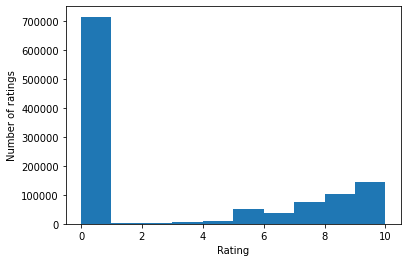

In [ ]:
import matplotlib.pyplot as plt

rating_distribution = rating.bookRating
plt.hist(rating_distribution)
plt.ylabel('Number of ratings')
plt.xlabel('Rating')
plt.show()

We can see that the majority of the ratings (700K out of 1200K scores in total) are 0 (implicit scores), and very few scores are 1, 2 or 3. In general, if a book achieves low scores it means that it has not been liked.

How many books has each user rated? To answer this question, let's draw the distribution of scores per user.


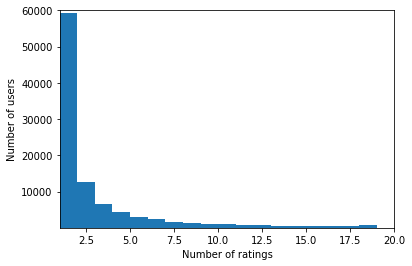

The user who has rated most books has rated: 13602


In [ ]:
# Count the number of entries in the rating matrix by user
Nrating_por_user = rating.userID.value_counts()
plt.hist(Nrating_por_user, range(20))
plt.ylim([1, 60000])
plt.xlim([1, 20])
plt.ylabel('Number of users')
plt.xlabel('Number of ratings')
plt.show()


print("The user who has rated most books has rated:", Nrating_por_user.max())

We see that this distribution has many values at the beginning and then shows a long tail... this shows that many users have rated very few books and there are few users with many rated books. Although there is one user who has rated 13602 books!!!!! 

And how many scores do we have for each book? Let's now show the distribution of ratings per book.



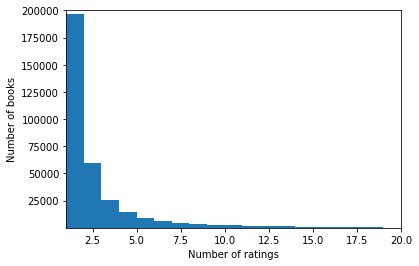

The highest rated book has: 2502


In [ ]:
Nrating_por_book = rating.bookID.value_counts()
plt.hist(Nrating_por_book, range(20))
plt.ylim([1, 200000])
plt.xlim([1, 20])
plt.ylabel('Number of books')
plt.xlabel('Number of ratings')
plt.show()

print("The highest rated book has:", Nrating_por_book.max())

We now see a similar distribution where most of the books received less than 5 ratings, and very few books have many ratings, although the highest rated book has received 2.502 ratings.

### Table of contents (books)

Let's now analyse the information in this table.

In [ ]:
url_books = "http://www.tsc.uc3m.es/~vanessa/Figs_notebooks/ML/SR/BX-Books.csv"

books = pd.read_csv(url_books, sep=';', error_bad_lines=False, encoding="latin-1", usecols=["ISBN", "Book-Title", "Book-Author", "Year-Of-Publication"], low_memory=False)
books.columns = ['bookID', 'title', 'author', 'year']  
books.head()

,bookID,title,author,year
0,0195153448,Classical Mythology,Mark P. O. Morford,2002
1,0002005018,Clara Callan,Richard Bruce Wright,2001
2,0060973129,Decision in Normandy,Carlo D'Este,1991
3,0374157065,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata,1999
4,0393045218,The Mummies of Urumchi,E. J. W. Barber,1999


In this case each row of the table is associated to a book and has the information of the book (ID, title, author and year).

### User table

Let's now analyse the information in the user table.

In [ ]:
url_users = "http://www.tsc.uc3m.es/~vanessa/Figs_notebooks/ML/SR/BX-Users.csv"

users = pd.read_csv(url_users, sep=';', error_bad_lines=False, encoding="latin-1")
users.columns = ['userID', 'localication', 'age']  
users.head()

,userID,localication,age
0,1,"nyc, new york, usa",NaN
1,2,"stockton, california, usa",18.0
2,3,"moscow, yukon territory, russia",NaN
3,4,"porto, v.n.gaia, portugal",17.0
4,5,"farnborough, hants, united kingdom",NaN


As in the content table, each row of the table is associated to a user and has the user's information. In this case their ID, location and year. We see that some fields are not available for some users and are listed as `NaN`.

### Data preprocessing

Before starting to work with this database, we are going to filter some of its fields based on two criteria:

1. We are going to eliminate implicit scores. Most of the models that we are going to see only work with explicit scores, so we are going to eliminate the implicit scores to facilitate the design of the models.

2. To reduce the size of the dataset, and avoid running into long runs, we are going to filter out books with few ratings and users who have scored few books. In fact, these users/books were not going to give us good results, so by eliminating them we facilitate the analysis of the methods we are going to study.




In [ ]:
print('The size of the original rating matrix is:\t{}'.format(rating.shape))
print('The size of the original user matrix is:\t{}'.format(users.shape))
print('The size of the original content matrix is:\t{}'.format(books.shape))

# 1. Remove implicit ratings

rating = rating[rating.bookRating>0]

# 2. Remove users and books with a low number of ratings

min_book_ratings = 50
filter_books = rating.bookID.value_counts() > min_book_ratings
filter_books = filter_books[filter_books].index.tolist()

min_user_ratings = 50
filter_users = rating.userID.value_counts() > min_user_ratings
filter_users = filter_users[filter_users].index.tolist()

rating = rating[(rating.bookID.isin(filter_books)) & (rating.userID.isin(filter_users))]
print('The size of the filtered rating matrix is:\t{}'.format(rating.shape))

users = users[(users.userID.isin(filter_users))]
print('The size of the filtered user matrix is:\t{}'.format(users.shape))

books = books[(books.bookID.isin(filter_books))]
print('The size of the filtered content matrix is:\t{}'.format(books.shape))

The size of the original rating matrix is:	(1149780, 3)
The size of the original user matrix is:	(278858, 3)
The size of the original content matrix is:	(271379, 4)
The size of the filtered rating matrix is:	(13716, 3)
The size of the filtered user matrix is:	(1295, 3)
The size of the filtered content matrix is:	(507, 4)


# 3. Recommender systems: what are they and how are they classified?

As we have seen, recommender systems start from information about the contents (`books`), the users (`users`) and the users' interests in some of the contents (`rating`) in order to predict the users' interest in the unrated books. In other words, fill in the blanks in the rating table.

Depending on the used information and how this information is used, we can classify recommender systems as:

*  **Popularity-based models**: these systems only consider the content popularity  (based on user ratings, number of sales,...). They are easy to implement and enjoy a certain level of effectiveness, but they do not provide personalised recommendations (they do not take into account the personal preferences of each user).

*  **Content-based systems**: the user is recommended similar items to those he liked in the past: "Show me more of the same items that I liked". This similarity between contents is done on the basis of the descriptions and characteristics of the contents (information about the books: similar title, same author, ...).

* **User-based systems**: a user is recommended based on the tastes of users with a similar socio-demographic profile (this approach is not usually used).

* **Collaborative filtering**: the user is recommended with items that were liked (in the past) by people with similar tastes and preferences. In other words, items rated positively by users who tend to agree with the user are recommended to the user.

* **Hybrids**: combine the above schemes to exploit the advantages and overcome limitations of the different approaches.

Two of the most popular approaches to recommender systems are collaborative filtering and content-based recommendations. In this notebook we are going to focus on collaborative filtering systems (the most common); but first let's review a couple of simple approaches to design a popularity-based system and a content-based system.

## 3.1 Popularity-based systems

As mentioned above, one of the simplest recommendation methods are popularity-based systems. This approach recommends the most important items based on a certain metric or score (popularity). 

In this section, we are going to design one of these systems for our book recommendation database. To do so, we will follow the steps below:
1. Select a popularity criterion, metric or score to rate the books.
2. Calculate the popularity of each book.
3. Sort the books according to their popularity to generate a list of recommendations.


One of the simplest metrics could be to consider the average rating to each book or directly select the books with a high number of scores.

Let's analyze these two metrics. To do so, complete the following exercises:

**Exercise 1**: Calculate the average rating for each book and show the 10 books with the highest average rating.

**Exercise 2**: Calculate the number of ratings for each book and display the 10 books with the highest number of ratings.

If you find it useful, you can use the `groupby` and `agg` functions of the `dataframes` (you can find their help [here](https://pandas.pydata.org/pandas-docs/version/0.23.1/generated/pandas.core.groupby.DataFrameGroupBy.agg.html) and [here](https://pandas.pydata.org/pandas-docs/version/0.23.1/api.html#id39)).


#### Solution

In [ ]:
# Exercise 1
#<SOL>
# Get the average rating and the number of ratings by book 
book_rating = rating.groupby('bookID', as_index=False)['bookRating'].agg({'meanRating' : 'mean', 'numRating' : 'size'})

# Just for analysis purposes, add title to the previous dataframe
book_rating = pd.merge(book_rating, books[['bookID','title']], on='bookID')

# Show the books with highest mean rating
book_rating = book_rating.sort_values(ascending=False,by=['meanRating'])
book_rating.head(10)
#</SOL>

,bookID,meanRating,numRating,title
112,0345339738,9.500000,20,"The Return of the King (The Lord of the Rings,..."
241,043936213X,9.437500,16,Harry Potter and the Sorcerer's Stone (Book 1)
58,0156528207,9.357143,14,The Little Prince
492,1400032717,9.300000,10,The Curious Incident of the Dog in the Night-T...
370,0553274295,9.263158,19,Where the Red Fern Grows
316,0449005615,9.230769,26,Seabiscuit: An American Legend
33,0064400557,9.218750,32,Charlotte's Web (Trophy Newbery)
238,0439139597,9.190476,63,Harry Potter and the Goblet of Fire (Book 4)
114,0345348036,9.181818,22,The Princess Bride: S Morgenstern's Classic Ta...
144,0345465083,9.142857,14,Seabiscuit


In [ ]:
# Exercise 2
#<SOL>
# Show the books with highest number of ratings
book_rating = book_rating.sort_values(ascending=False,by=['numRating'])
book_rating.head(10)
#</SOL>

,bookID,meanRating,numRating,title
91,0316666343,8.174825,143,The Lovely Bones: A Novel
199,0385504209,8.553398,103,The Da Vinci Code
393,059035342X,8.943182,88,Harry Potter and the Sorcerer's Stone (Harry P...
240,043935806X,8.925926,81,Harry Potter and the Order of the Phoenix (Boo...
60,0312195516,8.512500,80,The Red Tent (Bestselling Backlist)
108,0345337662,7.486842,76,Interview with the Vampire
280,0446310786,9.013699,73,To Kill a Mockingbird
53,0142001740,8.708333,72,The Secret Life of Bees
245,044021145X,7.746479,71,The Firm
121,0345370775,7.671429,70,Jurassic Park


**Designing our popularity metric**.

What are the potential drawbacks of the above metrics? 

* Using only the number of ratings we see that it doesn't make much sense because the most rated books can have bad ratings.

* But using the average rating can give us problems because some books can have a very high score and be unreliable because they have few ratings... For example, "The Curious Incident of the Dog in the Night-T..." has a 9.3 with only 10 votes, and "Harry Potter and the Goblet of Fire" has an average score of 9.19 with 63 votes. Which would you recommend first with a highest confidence? 	

    
Looking at this, it seems most appropriate to use a metric that takes into account both the average rating and the accumulated number of votes. This system will ensure that, for example, a book with an average score of 6 with 500 votes will get a (much) higher score than a film with the same score but only a few votes.

IMDB ([Internet Movie Database](https://www.imdb.com/)) assigns the popularity of its films with this formula:
$$ {\rm Weighted~Rating~(WR)}=\frac{v}{v+m}R+\frac{m}{v+m}C$$
where,
   * $v$ is the number of ratings;
   * $m$ is the minimum number of votes required for its average rating to be significant;
   * $R$ average rating;
   * $C$ average rating over all items.

If $v>>m$, ${\rm WR} = R$, having many ratings we rely on its average rating; but if $m>>v$, ${\rm WR} = C$, we do not rely on the ratings and the assigned popularity is the average of the whole database.

Let's calculate this metric for our book collection.



**Exercise 3**: Calculate the WR index for each of the books of our database and show the 10 books with the highest index. Set the value of $m$ to 10.

#### Solution


In [ ]:
# m fixed to 10
m = 10

#<SOL>
# C is computed from the rating matrix
C = rating['bookRating'].mean()

# v y R are already computed in book_rating

## Compute WR

book_rating['WR'] = book_rating['numRating']/(book_rating['numRating']+m)*book_rating['meanRating'] + m/(book_rating['numRating']+m) *C
book_rating = book_rating.sort_values(ascending=False,by=['WR'])
book_rating.head(10)
#</SOL>


,bookID,meanRating,numRating,title,WR
238,0439139597,9.190476,63,Harry Potter and the Goblet of Fire (Book 4),9.028985
112,0345339738,9.500000,20,"The Return of the King (The Lord of the Rings,...",9.003864
236,0439136350,9.129032,62,Harry Potter and the Prisoner of Azkaban (Book 3),8.973832
33,0064400557,9.218750,32,Charlotte's Web (Trophy Newbery),8.931332
280,0446310786,9.013699,73,To Kill a Mockingbird,8.892963
316,0449005615,9.230769,26,Seabiscuit: An American Legend,8.892109
241,043936213X,9.437500,16,Harry Potter and the Sorcerer's Stone (Book 1),8.889074
239,0439139600,9.114286,35,Harry Potter and the Goblet of Fire (Book 4),8.869243
393,059035342X,8.943182,88,Harry Potter and the Sorcerer's Stone (Harry P...,8.848122
370,0553274295,9.263158,19,Where the Red Fern Grows,8.831584


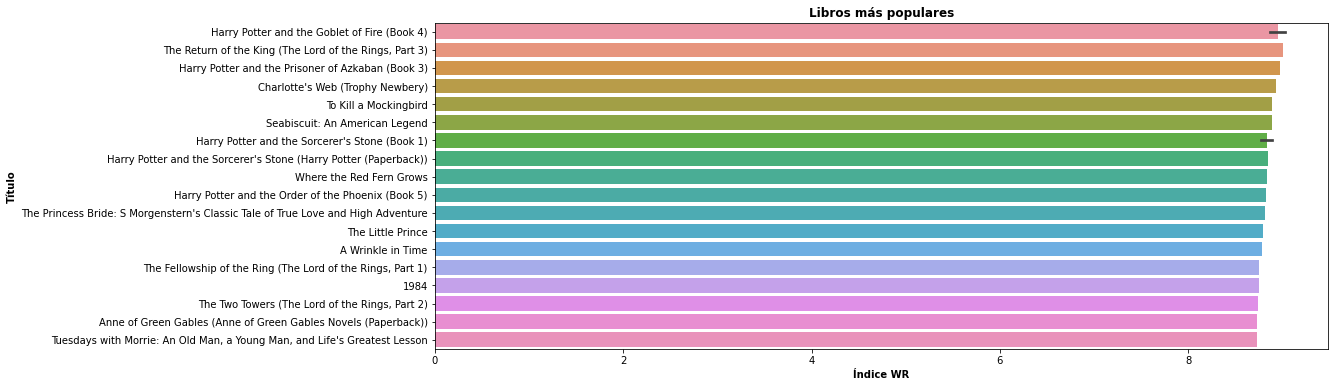

In [ ]:
import seaborn as sns
# To plot the result
plt.figure(figsize=(16,6))
sns.barplot(x='WR',y='title', data=book_rating.head(20))

plt.title('Libros más populares', weight='bold')
plt.xlabel('Índice WR', weight='bold')
plt.ylabel('Título', weight='bold')
plt.show()

In [ ]:
# To print the result
book_rating.head(20)

,bookID,meanRating,numRating,title,WR
238,0439139597,9.190476,63,Harry Potter and the Goblet of Fire (Book 4),9.028985
112,0345339738,9.500000,20,"The Return of the King (The Lord of the Rings,...",9.003864
236,0439136350,9.129032,62,Harry Potter and the Prisoner of Azkaban (Book 3),8.973832
33,0064400557,9.218750,32,Charlotte's Web (Trophy Newbery),8.931332
280,0446310786,9.013699,73,To Kill a Mockingbird,8.892963
316,0449005615,9.230769,26,Seabiscuit: An American Legend,8.892109
241,043936213X,9.437500,16,Harry Potter and the Sorcerer's Stone (Book 1),8.889074
239,0439139600,9.114286,35,Harry Potter and the Goblet of Fire (Book 4),8.869243
393,059035342X,8.943182,88,Harry Potter and the Sorcerer's Stone (Harry P...,8.848122
370,0553274295,9.263158,19,Where the Red Fern Grows,8.831584


## 3.2 Content-based systems

In this section we are going to review content based systems. In this case, given a user, we are going to recommend books similar to the books he has already liked. To obtain the book similarities, we will use the descriptive information of each book. If we look at the `books` table, we see that we have the following information:


In [ ]:
books.head()

,bookID,title,author,year
18,0440234743,The Testament,John Grisham,1999
19,0452264464,Beloved (Plume Contemporary Fiction),Toni Morrison,1994
26,0971880107,Wild Animus,Rich Shapero,2004
27,0345402871,Airframe,Michael Crichton,1997
28,0345417623,Timeline,MICHAEL CRICHTON,2000


* **Title**: we could analyse the semantic content of the titles to find books with similar topics. In fact, for this type of processing it would be interesting to have a summary of the book that is more descriptive of its content and, then, you can use many of the approaches learnt in the NLP block (topic models, word2vec, ...).
* **Author**: in this case we can directly say that two books are similar if they were written by the same author.
* **Year**: we could consider the year as another similarity variable, although it would only make sense if we combine it with any of the previous criteria.

With this information and to build a simple system (not including NLP methods), we can apply the following criterion to build a list of similar books: "*two books are similar if they are by the same author and are more similar if they have been published closer in time*".

To build this system let's solve the following exercises:


### **Exercise 4**
Complete the following code cell to given a `bookID`, build a dataframe (`books_author`) with all the books of the `bookID` author.

*Note*: you can use the `.loc()` method of the DataFrames to make selection of rows that meet a certain condition.

#### Solution

In [ ]:
bookId = '0345402871'	

# Preprocess authors: convert all characters to lowercase
books['author'] = books['author'].str.lower()

#<SOL>
book_info = books.loc[books['bookID'] == bookId]
author = book_info['author'].values[0]
books_author = books.loc[books['author'] == author]
books_author 
#</SOL>


,bookID,title,author,year
27,0345402871,Airframe,michael crichton,1997
28,0345417623,Timeline,michael crichton,2000
207,0345378490,Congo,michael crichton,1995
1195,0345370775,Jurassic Park,michael crichton,1999
1860,0345380371,Rising Sun,michael crichton,1992
1947,034540288X,The Lost World,michael crichton,1996
2241,0345378482,The Andromeda Strain,michael crichton,1992
2430,0061015725,Prey,michael crichton,2003
2442,0345353145,Sphere,michael crichton,1988
4723,0345391055,Disclosure,michael crichton,1994


###**Exercise 5**
For the `books_author` dataframe include a new column with the difference in years between the `bookId` publication year and the rest of the books in the dataframe. Then, build the `similar_books` dataframe by sorting the rows of `books_author` so that the books closest in time to `bookID` come first. It may be advisable to remove the reference book entry (the row with `bookID='0345402871'`) from this dataframe.

#### Solution

In [ ]:
# Preprocess years: convert to integer
books_author['year'] = books_author['year'].astype(int)

#<SOL>
year = int(book_info['year'].values[0])
books_author.loc[:,'dist_year'] = (books_author['year']-year).abs()  
similar_books = books_author.sort_values(ascending=True,by=['dist_year']) 
  
# Remove bookID
similar_books = similar_books[similar_books['bookID'] != bookId ]
similar_books
#</SOL>

,bookID,title,author,year,dist_year
1947,034540288X,The Lost World,michael crichton,1996,1
207,0345378490,Congo,michael crichton,1995,2
1195,0345370775,Jurassic Park,michael crichton,1999,2
6621,0679444815,Timeline,michael crichton,1999,2
28,0345417623,Timeline,michael crichton,2000,3
4723,0345391055,Disclosure,michael crichton,1994,3
4984,0451183665,A Case of Need,michael crichton,1994,3
1860,0345380371,Rising Sun,michael crichton,1992,5
2241,0345378482,The Andromeda Strain,michael crichton,1992,5
4941,0066214122,Prey: A Novel,michael crichton,2002,5


**Exercise 6**
Let's now combine the solutions of Exercises 4 and 5 to build a function that, given a `bookId`, returns the list of most similar books (by the same author and closest in time).

#### Solution

In [ ]:
def find_similar_books(bookId):
  #<SOL>
  
  # Preprocess authors: convert all characters to lowercase
  books['author'] = books['author'].str.lower()
  # Preprocess years: convert to integer
  books['year'] = books['year'].astype(int)
  book_info = books.loc[books['bookID'] == bookId]
  author = book_info['author'].values[0]
  year = book_info['year'].values[0]
  books_author = books.loc[books['author'] == author]

  books_author['dist_year'] = (books_author['year']-year).abs()

  similar_books = books_author.sort_values(ascending=True,by=['dist_year']) 
  # Remove bookID
  similar_books = similar_books[similar_books['bookID'] != bookId ]

  #</SOL>
  return similar_books

bookId = '0345402871'	

similar_books = find_similar_books(bookId)

similar_books

,bookID,title,author,year,dist_year
1947,034540288X,The Lost World,michael crichton,1996,1
207,0345378490,Congo,michael crichton,1995,2
1195,0345370775,Jurassic Park,michael crichton,1999,2
6621,0679444815,Timeline,michael crichton,1999,2
28,0345417623,Timeline,michael crichton,2000,3
4723,0345391055,Disclosure,michael crichton,1994,3
4984,0451183665,A Case of Need,michael crichton,1994,3
1860,0345380371,Rising Sun,michael crichton,1992,5
2241,0345378482,The Andromeda Strain,michael crichton,1992,5
4941,0066214122,Prey: A Novel,michael crichton,2002,5


### And how do we make recommendations to a user?

Now that we know how to find similar books, we just need to look at the books that the user has previously rated a positive (he liked them) in order to recommend the books similiar to these.

In [ ]:
rating.head()

,userID,bookID,bookRating
1456,277427,002542730X,10
1474,277427,0061009059,9
1522,277427,0316776963,8
1543,277427,0345413903,10
1581,277427,0385486804,9


In [ ]:
# We choose a user and see their previous likes and dislikes.

userId = 277427

ratings_userID = rating.loc[rating['userID'] == userId]
ratings_userID.sort_values(ascending=False,by=['bookRating']) 

,userID,bookID,bookRating
1456,277427,002542730X,10
1543,277427,0345413903,10
1474,277427,0061009059,9
1581,277427,0385486804,9
1601,277427,0399501487,9
1718,277427,0553280368,9
1776,277427,0679731148,9
1799,277427,0743412028,9
1522,277427,0316776963,8
1584,277427,0385504209,8


We see that this user really liked the books: `002542730X`, `0345413903`, ..., `0743412028` so we can recommend books similar to these...

In [ ]:
list_books = ['002542730X', '0345413903', '0061009059', '0385486804', '0399501487', '0553280368', '0679731148', '0743412028']
for bookId in  list_books:
  title = books.loc[books['bookID'] == bookId]['title']

  print('Books similar to '+title+':' ) 
  similar_books = find_similar_books(bookId)
  print(similar_books['title'].values)

3739    Books similar to Politically Correct Bedtime S...
Name: title, dtype: object
[]
1988    Books similar to The Murder Book:
Name: title, dtype: object
['Flesh and Blood']
669    Books similar to One for the Money (Stephanie ...
Name: title, dtype: object
['Two for the Dough'
 'Three To Get Deadly : A Stephanie Plum Novel (A Stephanie Plum Novel)'
 'Four To Score (A Stephanie Plum Novel)'
 'High Five (A Stephanie Plum Novel)'
 'Hot Six : A Stephanie Plum Novel (A Stephanie Plum Novel)'
 "Full House (Janet Evanovich's Full Series)"
 'Seven Up (A Stephanie Plum Novel)' 'Visions of Sugar Plums'
 'Hard Eight : A Stephanie Plum Novel (A Stephanie Plum Novel)'
 'One for the Money (A Stephanie Plum Novel)'
 'To the Nines: A Stephanie Plum Novel'
 'Hard Eight : A Stephanie Plum Novel (A Stephanie Plum Novel)'
 "Full Tilt (Janet Evanovich's Full Series)"]
1793    Books similar to Into the Wild:
Name: title, dtype: object
['Into Thin Air : A Personal Account of the Mt. Everest Disaster']
17

# Collaborative filtering

Collaborative filtering systems look for similarities between users/contents based on the ratings that users have given to the contents. They do not make use of user demographic information or metadata associated with the contents.

These systems are divided into two types:

1. **User-based filtering**: these systems make recomendations to a user based in the contents liked by users with similar preferences. For example, let's say Alice and Mary have similar tastes in books (i.e. they largely like and dislike the same books). Let's say a new book has been released and Alice has read it and liked it. Therefore, it is very likely that Mary would also like it, and therefore, the system would recommend this book to Mary.

2. **Content-based filtering**: these systems are similar to the system we have just designed (content-based), except for the fact that the similarities between the contents (or items) are calculated based on the ratings given to them by the users. For example, if Alice, Mary and Anne have given 5 stars to the Harry Potter and Twilight books, the system identifies the items as similar. Therefore, if someone buys one of the Harry Potter books, the system also recommends the Twilight saga.

To design these systems we only need the rating matrix!!!

## 4.1 User-based collaborative filtering

Given the "active user" (Alice) and an item ($i$) that she has not yet seen, these systems work as follows:
1. They find the set of users who are most similar to Alice (they liked similar objects) and, in addition, have rated the item $i$.
2. Then, to predict the rating that Alice would give  to the item $i$, they use the average of the ratings that these users (those who have similar preferences to Alice) have given to item $i$.

Applying this process on all the objects that Alice has not rated yet, we could obtain some predictions of their scores with which we can make a ranking and, then, recommend to Alice the ones that we believe would have a higher rating.

Let's see in detail how to carry out this process with the following example:

<img align="center" src="http://www.tsc.uc3m.es/~vanessa/Figs_notebooks/ML/SR/CF_user2user_1.png" width=60% >


**Step 1**: Let's calculate the similarity between users. 

To measure whether two users $u$ and $v$ are similar, it is common to use the correlation coefficient between the vectors of common scores, i.e., given the subset ($I_{u,v}$) of items that both users have scored, their similarity is given by:
$${\rm sim}(u,v) = \frac{\sum_{i \in I_{u,v}}  r_{u,i}  r_{v,i}  }{\sqrt{\sum_{i \in I_{u,v}} r_{u,i}^2  \sum_{i \in I_{u,v}}r_{v,i}^2}}$$
where $r_{u,i}$ is the score that user $u$ has given to item $i$. Thus, we can have that Alice has the following similarities with the rest of the users:

<img align="centre" src="http://www.tsc.uc3m.es/~vanessa/Figs_notebooks/ML/SR/CF_user2user_2.png" width=80%>




**Step 2**: Let's make predictions about the ratings.

Now to find out the rating that Alice would give to Item 5 we can take the most similar users to Alice ($N_A$) and average the scores that these users have given to Item 5, weighting them by their similarities, i.e.:
$$ \hat{r}_{A,Item5} = \frac{\sum_{v \in N_A} {\rm sim}(A,v) ~r_{v,Item5} }{\sum_{v \in N_A} {\rm sim}(A,v)} $$

In our example, we only use users 1 and 2 as similar users, so we would have:
$$ \hat{r}_{A,Item5} = \frac{0.85·3 + 0.7·5 }{0.85+ 0.7} = 3.9 $$ 

In general, for a user $u$ the estimated score on item $i$ is given by
$$ \hat{r}_{u,i} = \frac{\sum_{v \in N_u^K} {\rm sim}(u,v) ~r_{v,i} }{\sum_{v \in N_u^K} {\rm sim}(u,v)} $$
where $N_u^K$ are the $K$ most similar neighbours to the user $u$.




Although in this example users are rating items on a scale between 0 and 5, there is no guarantee that all users will interpret the scale equally or that some users will be more or less generous in their ratings. To correct for these effects, we may find modifications to the above model by including normalised versions of the ratings.

Normally, there are two variants:
* **Average correction**: in this case, the average value of the user's scores is taken away from each score, i.e, 
$$ r_{u,i}^{norm} = r_{u,i} - \bar{r_{u}}$$
where $\bar{r_{u}}$ is the mean value of the scores given by the user $u$.
* **z-score correction**: in this case both the mean and the standard deviation are adjusted, resulting in a new rating or score called z-score that tries to make the distribution of the scores of all users the same. This new normalised score is given by:
$$ r_{u,i}^{norm} = \frac{r_{u,i} - \bar{r_{u}}}{std(r_{u})}$$

where $\bar{r_{u}}$ and $std(r_{u})$ are, respectively, the mean value and the standard deviation of the ratings given by the user $u$.


## 4.2 Content-based collaborative filtering

The working principles of this system are very similar to the previous one, but we will use the similarities between objects (and not between users) to make the predictions.
For example, going back to our example

<img align="centre" src="http://www.tsc.uc3m.es/~vanessa/Figs_notebooks/ML/SR/CF_item2item.png" width=60%>

To do this, we can measure the similarity between items $i$ and $j$ as the correlation between the ratings given by the users who have rated both items
$${\rm sim}(i,j) = \frac{\sum_{u \in U_{i,j}}  r_{u,i}  r_{u,j}  }{\sqrt{\sum_{u \in U_{i,j}} r_{u,i}^2  \sum_{u \in U_{i,j}}r_{u,j}^2}}$$

where $U_{i,j}$ is the set of users who have rated both items. Applying this expression to our example, we see that the items most similar to Item 5 are Item 1 and Item 4. 

We can then use the ratings given by Alice to the set of contents similar to Item 5 ($N_{Item5}$) to make predictions:


$$ \hat{r}_{A,Item5} = \frac{\sum_{j \in N_{Item5}} {\rm sim}(Item5,j) r_{A,j} }{\sum_{j \in N_{Item5}} {\rm sim}(Item5,j)} $$

which for our example would give us that $\hat{r}_{A,Item5}=4.7$.

For a general case, the estimated rating for a user $u$ on item $i$ is given by
$$ \hat{r}_{u,i} = \frac{\sum_{j \in N_i^K} {\rm sim}(i,j) r_{u,j} }{\sum_{j \in N_i^K} {\rm sim}(i,j)}$$

where now $N_i^K$ are the $K$ most similar neighbours to item $i$.

Finally, if we wish, we can also apply the mean or z-score corrections to homogenise the ranges of scores between users.

And now that I know some of the collaborative filtering models, how do I apply them to my book recommendation problem?

We could implement these models in Python and design our own functions, but here we are going to make use of one of the most widely used Python libraries for Recommender Systems: [Surprise](http://surpriselib.com/)

# 5. SURPRISE

The [SurPRISE](http://surpriselib.com/) library (Simple Python RecommendatIon System Engine) facilitates the design of recommendation systems (especially collaborative filtering systems) by including tools for:

* Manage data (especially rating matrices). Users can use built-in datasets (Movielens, Jester) or own databases.
* Train multiple collaborative filtering algorithms: the ones we have just seen based on neighbourhood between users or between content, as well as other collaborative filtering methods that we will see later.
* Facilitate the evaluation, analysis and comparison of the performance of different methods. 
* Perform parameter tuning. This includes cross-validation procedures.

All these methods or tools have a very similar syntax to those of sklearn, so they are very easy to use.

Let's see how to work with this library on our example. Let's start by installing Surprise in Colab.

In [ ]:
!pip install scikit-surprise

     |████████████████████████████████| 11.8MB 301kB/s 
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.1-cp37-cp37m-linux_x86_64.whl size=1617558 sha256=f76f5f3c4862e09bb3b2134247e7c149071dff53242c08d18e1496cfe50bb973
  Stored in directory: /root/.cache/pip/wheels/78/9c/3d/41b419c9d2aff5b6e2b4c0fc8d25c538202834058f9ed110d0
Successfully built scikit-surprise


## 5.1. Loading and preprocessing data in Surprise

To load a dataset from a dataframe into *Surprise*, we can use the `load_from_df()` method. To do this, we need a dataframe with three columns (in this order): 
* user ids,
* content ids,
* assigned scores/ratings.

In addition, this function uses a `Reader` object where we have to specify with the `rating_scale` parameter the range of the rating values (in our case from 1 to 10).




In [ ]:
from surprise import Reader, Dataset

reader = Reader(rating_scale=(1,10))
data = Dataset.load_from_df(rating[['userID', 'bookID', 'bookRating']], reader)

Let's see the before and after...

In [ ]:
rating.head()

,userID,bookID,bookRating
1456,277427,002542730X,10
1474,277427,0061009059,9
1522,277427,0316776963,8
1543,277427,0345413903,10
1581,277427,0385486804,9


In [ ]:
print(type(data))
data.raw_ratings[:10]

<class 'surprise.dataset.DatasetAutoFolds'>


[(277427, '002542730X', 10.0, None),
 (277427, '0061009059', 9.0, None),
 (277427, '0316776963', 8.0, None),
 (277427, '0345413903', 10.0, None),
 (277427, '0385486804', 9.0, None),
 (277427, '0385504209', 8.0, None),
 (277427, '0399501487', 9.0, None),
 (277427, '0440224764', 7.0, None),
 (277427, '0452284449', 6.0, None),
 (277427, '0552137030', 8.0, None)]

*Note*: The last column is used in datasets that have predefined partitions, in our case there are none and their values are set to `None`.

To train our model, as when working with classification/regression models, it is appropriate to split the training set into training and test partitions. To do this we can use the `train_test_split()` function.

In [ ]:
from surprise.model_selection import train_test_split

trainset, testset = train_test_split(data, test_size=0.25)

Looking at this code, everything looks very simple and similar to our working procedure in sklearn. But **be careful**, Surprise handles different data types, and when we apply these conversions it generates different data types and it uses internal indexes for users and items...

In [ ]:
print(type(trainset))
# This object allows to obtain the tuples (id_u, id_i, rating) with the .all_ratings() method.
print('Rating values')
print(list(trainset.all_ratings())[:10])
# We can use the functions .to_raw_iid(), .to_raw_uid to convert the internal ids to the original ones.
# Or the functions .to_inner_iid() and .to_inner_uid() to undo this conversion.

<class 'surprise.trainset.Trainset'>
Rating values
[(0, 0, 7.0), (0, 261, 9.0), (0, 143, 9.0), (0, 276, 10.0), (0, 228, 8.0), (0, 333, 8.0), (0, 384, 9.0), (0, 304, 9.0), (0, 485, 8.0), (0, 24, 8.0)]


In [ ]:
print(type(testset))
testset[:10]

<class 'list'>


[(246513, '006016848X', 9.0),
 (242083, '0451524934', 7.0),
 (92652, '006101351X', 5.0),
 (11676, '067102423X', 8.0),
 (51450, '0446610038', 10.0),
 (93629, '0380018179', 6.0),
 (130571, '0786868716', 6.0),
 (220240, '014100018X', 6.0),
 (26544, '0451203895', 7.0),
 (142524, '0802130208', 8.0)]

As we will see, these objects, `trainset` and `testset`, are the ones used, respectively, by the `.fit()` and `.predict()` methods of the different models. If we want to train a model with the original dataset, we would have to convert the `surprise.dataset.DatasetAutoFolds` data type to `surprise.trainset.Trainset` or we will have to turn it into a `list` if we want to make predictions. This can be done with the functions `build_full_trainset()` and `build_testset()` or `build_anti_testset()` as shown in the following example:

In [ ]:
# To check we print the number of ratings in data
print('Original data')
print(len(data.raw_ratings))

# We generate a set of ratings with the training data.
trainset_all = data.build_full_trainset()
print('Training data')
print(type(trainset_all))
print(trainset_all.n_ratings)

# We generate a test set with the training data (to compute training  performance).
testset_all = trainset_all.build_testset()
print('Test data (with the taining samples)')
print(type(testset_all))
print(len(testset_all))

# We generate a test set with the data that are not in training. 
# (all combinations of unrated users and items) 
testset_all_anti = trainset_all.build_anti_testset()
print('Test data (with data that are not in training)')
print(type(testset_all_anti))
print(len(testset_all_anti))


Original data
13716
Training data
<class 'surprise.trainset.Trainset'>
13716
Test data (with the taining samples)
<class 'list'>
13716
Test data (with data that are not in training)
<class 'list'>
587220


## 5.2 Training a model

As Sklearn, to train a model we just need to define the model with its constructor and then use the `.fit()` method to train it. To train a model based on neighbours, Surprise includes the following methods:

* [`KNNBasic`](https://surprise.readthedocs.io/en/stable/knn_inspired.html#surprise.prediction_algorithms.knns.KNNBasic): this is the basic collaborative filtering algorithm we have seen before. It implements collaborative filtering based on users or content as defined by the `user_based` parameter of [`sim_options`](https://surprise.readthedocs.io/en/stable/prediction_algorithms.html#similarity-measures-configuration).

* [`KNNWithMeans`](https://surprise.readthedocs.io/en/stable/knn_inspired.html#surprise.prediction_algorithms.knns.KNNWithMeans): the same algorithm as above but with mean correction.

* [`KNNNWithZScore`](https://surprise.readthedocs.io/en/stable/knn_inspired.html#surprise.prediction_algorithms.knns.KNNWithZScore): the same algorithm as the previous ones but with mean and standard deviation correction.  

When defining these models, Surprise allows us to select two parameters that affect the neighbourhood used to make the predictions. If we remember that the predictions are given by:

$$ \hat{r}_{u,i} = \frac{\sum_{v \in N_u^K} {\rm sim}(u,v) r_{v,i} }{\sum_{v \in N_u^K} {\rm sim}(u,v)} $$

where $N_u^K$ are the $K$ most similar neighbours to the user $u$, Surprise lets us control this neighbourhood with these parameters:
* `k`: number of neighbours (users/items) that are considered to make the prediction (this is the size of the set $N_u^K$). If a user has more neighbours, only the `k` most similar are used. And if it has fewer, only those are used, unless they are less than `k_min`.
* `k_min`: minimum number of required neighbours of a user/item to make a prediction. For users/items with less than `k_min` neighbours, their predictions are maded based on their average ratings, i.e. on $\bar{r}_{u}$ or  $\bar{r}_{i}$.

Moreover, the class [`sim_options`](https://surprise.readthedocs.io/en/stable/prediction_algorithms.html#similarity-measures-configuration) not only allows us to select a model based on either users or contents, but also allows us to define several metrics, imported from the [`similarities`](https://surprise.readthedocs.io/en/stable/similarities.html#module-surprise.similarities) module, to find the most similar users or items to a given one. Specifically, it includes 4 metrics:

* `cosine`: Calculates the cosine similarity between all pairs of users (or items). For example, between users $u$ and $v$ this measure would be:
$${\rm sim}(u,v) = \frac{\sum_{i \in I_{u,v}}  r_{u,i}  r_{v,i}  }{\sqrt{\sum_{i \in I_{u,v}} r_{u,i}^2  \sum_{i \in I_{u,v}}r_{v,i}^2}}$$
where $I_{u,v}$ is the set of items that both users have scored.

* `msd`: Calculates the similarity as the inverse of the root mean square distance between all pairs of users (or items). In this case the similarity between users $u$ and $v$ is given by:
$${\rm sim}(u,v) = \frac{1}{1 + \sum_{i \in I_{u,v}}  \left(r_{u,i} - r_{v,i} \right)^2}$$
where a $+1$ term is included in the denominator to avoid divisions by $0$.

* `pearson`: Calculates the Pearson correlation coefficient between all pairs of users (or items), given by:
$${\rm sim}(u,v) = \frac{\sum_{i \in I_{u,v}}  \left(r_{u,i} - \bar{r_{u}}\right)  \left(r_{v,i}- \bar{r_{v}} \right) }{\sqrt{\sum_{i \in I_{u,v}} \left(r_{u,i} - \bar{r_{u}}\right)^2  \sum_{i \in I_{u,v}} \left( r_{v,i} - \bar{r_{v}}\right)^2}}$$
where $\bar{r_{u}}$  and $\bar{r_{v}}$ are the mean values of the user ratings $u$ and $v$.

* `pearson_baseline`: This is the same measure as before, except that instead of subtracting the averages from the ratings, it subtracts some mean coefficients that must be learnt (we will see later how to learn them). In addition, it includes a correction (*shrinkage*) to avoid overfitting effects when there are few common elements between users $u$ and $v$. With these changes this measure is given by:
$${\rm sim}(u,v) =\frac{\mid I_{u,v} \mid -1}{\mid I_{u,v} \mid -1+Sh} \frac{\sum_{i \in I_{u,v}}  \left(r_{u,i} - {b_{u}}\right)  \left(r_{v,i}- {b_{v}} \right) }{\sqrt{\sum_{i \in I_{u,v}} \left(r_{u,i} - {b_{u}}\right)^2  \sum_{i \in I_{u,v}} \left( r_{v,i} - {b_{v}}\right)^2}}$$
where ${b_{u}}$ and ${b_{v}}$ are the  mean coefficients of users $u$ and $v$ (which we will have to learn) and $Sh$ is the *shrinkage* coefficient which is a model parameter to be defined.

In addition, the similarity calculation includes the parameter `min_support` which indicates the minimum number of common items for the similarity to be calculated. If two users (or two items) do not have a minimum of `min_support` common elements scored, their similarity will be 0.

Now that we know the models included in Surprise, let's see how to define and train one of these models. Let's start with the simplest model, the `KNNBasic` with its default parameters.

In [ ]:
from surprise.prediction_algorithms.knns import KNNBasic

KNNalgo = KNNBasic()
KNNalgo.fit(trainset)

# Check the model parameters
print(KNNalgo.k)
print(KNNalgo.min_k)
print(KNNalgo.sim_options)

Computing the msd similarity matrix...
Done computing similarity matrix.
40
1
{'user_based': True}


If we want, we can modify these parameters in the constructor. For example, we can set a neighbourhood of 60 and a `k_min` value of 10.

In [ ]:
KNNalgo = KNNBasic(k=60, min_k=10)
KNNalgo.fit(trainset)

# Check the model parameters
print(KNNalgo.k)
print(KNNalgo.min_k)
print(KNNalgo.sim_options)

Computing the msd similarity matrix...
Done computing similarity matrix.
60
10
{'user_based': True}


We can even change the `sim_options` setting to make a content-based model using the `msd` as a measure of similarity between items.

In [ ]:
sim_options = {'name': 'msd', 'user_based': False}
KNNalgo = KNNBasic(k=60, min_k=10, sim_options = sim_options )
KNNalgo.fit(trainset)

# Check the model parameters
print(KNNalgo.k)
print(KNNalgo.min_k)
print(KNNalgo.sim_options)

Computing the msd similarity matrix...
Done computing similarity matrix.
60
10
{'name': 'msd', 'user_based': False}


## 5.3 Getting predictions 

Once the model is trained, in Surprise we can use the method [`.predict()`](https://surprise.readthedocs.io/en/stable/predictions_module.html#surprise.prediction_algorithms.predictions.Prediction) to get the prediction of a particular item for a given user. Or if we want to get the predictions for a test set (several users and items at once) we can use the `.test()` method. 


If we activate the `verbose` of the `predict` method, it returns information about the prediction. This information includes the actual value (if we tell it to do so when we call it), the predicted value and a `PredictionImpossible` flag that tells us if the prediction was possible. For example, in KNN methods if there are not enough neighbours (`min_k`) the prediction cannot be made and this method returns this exception and as  prediction provides the average value of the ratings.


#### **Exercise 7**: 
Estimate the rating of the first 4 items in the test set.

#### Solution

In [ ]:
# Check the four first elements in the test dataset
testset[:4]

[(246513, '006016848X', 9.0),
 (242083, '0451524934', 7.0),
 (92652, '006101351X', 5.0),
 (11676, '067102423X', 8.0)]

In [ ]:
#<SOL>
uid = 14521  # user id (integer)
iid = '0553268880'  # book id (string)

# get a prediction for specific users and items.
pred = KNNalgo.predict(uid, iid, verbose=True)
#</SOL>

user: 14521      item: 0553268880 r_ui = None   est = 8.02   {'was_impossible': True, 'reason': 'Not enough neighbors.'}


In [ ]:
#<SOL>
for sample in range(4):

  uid = testset[sample][0]  # user id (integer)
  iid = testset[sample][1]  # book id (string)
  rui = testset[sample][2]  # rating (we include it just for additional information)
  # get a prediction for specific users and items.
  pred = KNNalgo.predict(uid, iid, rui, verbose=True)
#</SOL>

user: 246513     item: 006016848X r_ui = 9.00   est = 8.02   {'was_impossible': True, 'reason': 'Not enough neighbors.'}
user: 242083     item: 0451524934 r_ui = 7.00   est = 8.28   {'actual_k': 21, 'was_impossible': False}
user: 92652      item: 006101351X r_ui = 5.00   est = 8.02   {'was_impossible': True, 'reason': 'User and/or item is unknown.'}
user: 11676      item: 067102423X r_ui = 8.00   est = 7.72   {'actual_k': 60, 'was_impossible': False}


#### **Exercise 8**:
Estimate the ratings of the whole test set.

#### Solution


In [ ]:
#<SOL>
# Get predictions
predictions = KNNalgo.test(testset)
# Check the output for the first values
print(predictions[:10])
#</SOL>

[Prediction(uid=246513, iid='006016848X', r_ui=9.0, est=8.01652571206377, details={'was_impossible': True, 'reason': 'Not enough neighbors.'}), Prediction(uid=242083, iid='0451524934', r_ui=7.0, est=8.27509004241595, details={'actual_k': 21, 'was_impossible': False}), Prediction(uid=92652, iid='006101351X', r_ui=5.0, est=8.01652571206377, details={'was_impossible': True, 'reason': 'User and/or item is unknown.'}), Prediction(uid=11676, iid='067102423X', r_ui=8.0, est=7.718444368415458, details={'actual_k': 60, 'was_impossible': False}), Prediction(uid=51450, iid='0446610038', r_ui=10.0, est=8.01652571206377, details={'was_impossible': True, 'reason': 'Not enough neighbors.'}), Prediction(uid=93629, iid='0380018179', r_ui=6.0, est=8.01652571206377, details={'was_impossible': True, 'reason': 'Not enough neighbors.'}), Prediction(uid=130571, iid='0786868716', r_ui=6.0, est=7.694441552541667, details={'actual_k': 15, 'was_impossible': False}), Prediction(uid=220240, iid='014100018X', r_ui=

## 5.4. Evaluating the model

Once we have the model predictions, we can use some of the following measures or metrics in the [accuracy](https://surprise.readthedocs.io/en/stable/accuracy.html) module to evaluate the model performance. In particular there are 4 measures to evaluate the error:

* `rmse`: Calculates the root mean squared error (RMSE, *Root Mean Squared Error*):
$$ RMSE = \sqrt{ \frac{1}{N} \sum_{i=1}^N (p_i -r_i)^2}$$
* `mse`: Calculates the mean squared error (MSE, *Mean Squared Error*):
$$ MSE = \frac{1}{N} \sum_{i=1}^N (p_i -r_i)^2$$
* `mae`: Calculates the mean absolute error (MAE, *Mean Absolute Error*):
$$MAE = \frac{1}{N} \sum_{i=1}^N |p_i -r_i|$$
* `fcp`: Calculates the fraction of concordant pairs (FCP, *Fraction of Concordant Pairs*). This measure is oriented to evaluate a ranking result and not the accuracy of the estimated vs the actual rating values. To do so, they measure the number of concordant pairs per user by counting the number of pairs:
$$n^u_c=\mid \{(i,j), ~ \hat{r}_{u,i}>\hat{r}_{u,j} ~~\rm{y} ~~~{r}_{u,i}>{r}_{u,j}\}\mid$$
and equivalently evaluate the number of discordant pairs $n^u_d$. Then, averaging these values over all users, $n_c = \sum_u n^u_c$ and $n_d = \sum_u n^u_d$, the FCP is defined as:
$$ FCP = \frac{n_c}{n_c+n_d}$$

To use these metrics we only need to call the corresponding function within the `accuracy` module by giving it the set of predictions we have estimated (note that in these predictions the actual rating values are also included, so the error can be calculated).


In [ ]:
from surprise import accuracy

# Compute performance 
RMSE = accuracy.rmse(predictions)

MSE = accuracy.mse(predictions)

MAE = accuracy.mae(predictions)

FCP = accuracy.fcp(predictions)

RMSE: 1.6473
MSE: 2.7137
MAE:  1.2643
FCP:  0.6322


## 5.5 Analysis of the influence of model parameters

So far, we have trained a simple KNN model, based on similarities between users, and we have used its default parameters.

In this section, we will see how the values of `K` and `k_min` influence on the model performance, the differences using a model based on user or content similarity, as well as the impact of using different similarity measures. Finally, we will see whether using other versions of the KNN model, such as those that include mean or z-score corrections, can provide advantages.

To do so, please complete the following exercises.

#### **Exercise 9**:
Analyse the influence of the value of `k` in the `KNNBasic` model (keep the remaining  parameters to their default values). Explore values in the range $[10,20,30,40,50]$ and measure the model performance in terms of RMSE.

#### Solution

Value of K: 10
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 1.7093
Value of K: 20
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 1.7070
Value of K: 30
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 1.7079
Value of K: 40
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 1.7080
Value of K: 50
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 1.7081
Value of K: 60
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 1.7081
Value of K: 70
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 1.7081


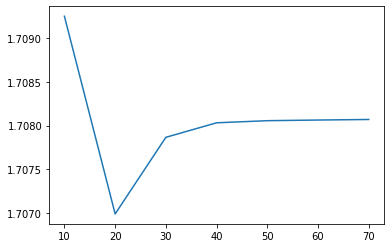

In [ ]:
#<SOL>
# Explore dependence with K: The (max) number of neighbors to take into account for aggregation
range_K = range(10,80,10)
RMSE_K=[]
for K in range_K:
  print('Value of K: ' + str(K))
  KNNalgo = KNNBasic(k=K)
  KNNalgo.fit(trainset)
  predictions = KNNalgo.test(testset)
  RMSE = accuracy.rmse(predictions)
  RMSE_K.append(RMSE)

plt.figure()
plt.plot(range_K, RMSE_K)
#</SOL>

#### **Exercise 10**:
Analyse the influence of the value of `min_k` on the `KNNBasic` model (set `k` to the best value from the previous section and keep the reamining parameters to their default values). Explore values in the range 1 to 20 and measure performance in terms of RMSE.

#### Solution

Value of min K: 1
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 1.7070
Value of min K: 2
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 1.6784
Value of min K: 3
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 1.6655
Value of min K: 4
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 1.6631
Value of min K: 5
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 1.6568
Value of min K: 6
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 1.6539
Value of min K: 7
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 1.6515
Value of min K: 8
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 1.6518
Value of min K: 9
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 1.6602
Value of min K: 10
Computing the msd similarity matrix...
Done c

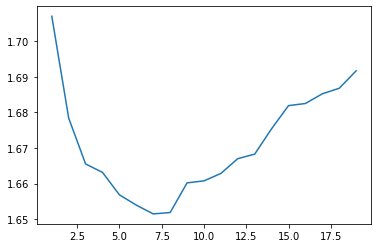

In [ ]:
#<SOL>
# Explore dependence with min_k: The minimum number of neighbors to take into account for aggregation. If there are not enough neighbors, the prediction is set to the global mean of all ratings. 
range_minK = range(1,20)
RMSE_minK = []
for minK in range_minK:
  print('Value of min K: ' + str(minK))
  KNNalgo = KNNBasic(k = 20, min_k = minK)
  KNNalgo.fit(trainset)
  predictions = KNNalgo.test(testset)
  RMSE = accuracy.rmse(predictions)
  RMSE_minK.append(RMSE)

plt.figure()
plt.plot(range_minK, RMSE_minK)
#</SOL>

#### **Exercise 11**:
Analyse the differences between using a user-based or content-based model and, in addition, the influence of using different similarity measures (`msd`, `cosine`, `pearson`, `pearson_baseline`). You can set `k` and `min_k` to the best values from the previous sections. Again, measure performance in terms of RMSE.

#### Solution

In [ ]:
#<SOL>
# Explore influence of the similarity measurement and user-based vs content based
user_based_list = [True, False]
list_sim = ['msd',  'cosine', 'pearson', 'pearson_baseline']
for user_based in user_based_list:
  for sim in list_sim:
    print('User based: ' + str(user_based))
    print('Similarity measurement: ' + sim)
    sim_options = {'name': sim, 'user_based': user_based}
    KNNalgo = KNNBasic(k = 20, min_k = 11, sim_options=sim_options)
    KNNalgo.fit(trainset)
    predictions = KNNalgo.test(testset)
    RMSE = accuracy.rmse(predictions)
#</SOL>

User based: True
Similarity measurement: msd
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 1.6628
User based: True
Similarity measurement: cosine
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 1.6895
User based: True
Similarity measurement: pearson
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 1.7099
User based: True
Similarity measurement: pearson_baseline
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE: 1.7042
User based: False
Similarity measurement: msd
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 1.6578
User based: False
Similarity measurement: cosine
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 1.6604
User based: False
Similarity measurement: pearson
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 1.

#### **Exercise 12**:
Finally, analyse whether the modified versions of the `KNNBasic` model (`KNNWithMeans` and `KNNWithZScore`) provide any advantages over the basic model. You can use for this analysis the best parameter settings obtained in the previous sections.

#### Solution

In [ ]:
from surprise.prediction_algorithms import KNNBasic, KNNWithMeans, KNNWithZScore

#<SOL>
sim_options = {'name': 'cosine', 
               'user_based': False  # compute  similarities between items
               }
            
print('KNNBasic')
KNNalgo = KNNBasic(k = 20, min_k = 11, sim_options=sim_options)
KNNalgo.fit(trainset)
predictions = KNNalgo.test(testset)
RMSE = accuracy.rmse(predictions)

print('KNNWithMeans')
KNNalgo = KNNWithMeans(k = 20, min_k = 11, sim_options=sim_options)
KNNalgo.fit(trainset)
predictions = KNNalgo.test(testset)
RMSE = accuracy.rmse(predictions)

print('KNNWithZScore')
KNNalgo = KNNWithZScore(k = 20, min_k = 11, sim_options=sim_options)
KNNalgo.fit(trainset)
predictions = KNNalgo.test(testset)
RMSE = accuracy.rmse(predictions)
#</SOL>

KNNBasic
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 1.6604
KNNWithMeans
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 1.6053
KNNWithZScore
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 1.6095


## 5.6 Parameter validation

Surprise provides several tools to run cross-validation procedures to find the best parameters for a given algorithm. The tools are easy to use, as they follow the sklearn format.

On the one hand, it has functions to generate training and test partitions (like the one we have used above) or to generate different validation partitions within the training set (in this [link](https://surprise.readthedocs.io/en/stable/model_selection.html#module-surprise.model_selection.split) you can find a detail of all of them).

On the other hand, similar to sklearn  `GridSearch` module, Surprise includes the `GridSearchCV` function that allows us to define a model, the parameters to explore and it does all the magic for us.

To see how it works, let's train a basic neighbourhood recommendation model (`KNNBasic`) based on content (`'user_based': False`) and select by CV the number of neighbours (`k`) and the minimum number of neighbours (`min_k`). 

Note: The Gridsearch function is designed to work with data of type `surprise.dataset.DatasetAutoFolds`. So, for this example, we will forget about the training/test partitions we have created and we will validate the model using all the data in `data`. Later we will see how we can use our training and test partitions.

In [ ]:
from surprise.model_selection.search import GridSearchCV

param_grid = {'k': range(10,50,10), 'min_k': range(1,10),
              'sim_options': {'name': ['cosine'],
                              'user_based': [False]}}
gs = GridSearchCV(KNNBasic, param_grid, measures=['rmse', 'mse'], cv=3)

gs.fit(data)

Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing th

We can analyse the results of the CV process by analysing the content of `cv_results`.

In [ ]:
results_df = pd.DataFrame.from_dict(gs.cv_results)
results_df.head()

,split0_test_rmse,split1_test_rmse,split2_test_rmse,mean_test_rmse,std_test_rmse,rank_test_rmse,split0_test_mse,split1_test_mse,split2_test_mse,mean_test_mse,std_test_mse,rank_test_mse,mean_fit_time,std_fit_time,mean_test_time,std_test_time,params,param_k,param_min_k,param_sim_options
0,1.654877,1.728554,1.708213,1.697215,0.031068,36,2.738616,2.987901,2.917990,2.881502,0.104989,36,0.091155,0.010150,0.157905,0.002709,"{'k': 10, 'min_k': 1, 'sim_options': {'name': ...",10,1,"{'name': 'cosine', 'user_based': False}"
1,1.622242,1.686382,1.671173,1.659932,0.027365,18,2.631670,2.843885,2.792818,2.756124,0.090438,18,0.082348,0.005923,0.152229,0.006002,"{'k': 10, 'min_k': 2, 'sim_options': {'name': ...",10,2,"{'name': 'cosine', 'user_based': False}"
2,1.623205,1.672966,1.661380,1.652517,0.021260,13,2.634794,2.798816,2.760185,2.731265,0.070015,13,0.079236,0.002200,0.147730,0.006347,"{'k': 10, 'min_k': 3, 'sim_options': {'name': ...",10,3,"{'name': 'cosine', 'user_based': False}"
3,1.623251,1.673491,1.658997,1.651913,0.021113,10,2.634943,2.800573,2.752272,2.729263,0.069548,10,0.080176,0.001435,0.185613,0.041205,"{'k': 10, 'min_k': 4, 'sim_options': {'name': ...",10,4,"{'name': 'cosine', 'user_based': False}"
4,1.632681,1.670929,1.671165,1.658258,0.018086,15,2.665646,2.792003,2.792792,2.750147,0.059752,15,0.079315,0.000838,0.154937,0.005746,"{'k': 10, 'min_k': 5, 'sim_options': {'name': ...",10,5,"{'name': 'cosine', 'user_based': False}"


Or we can directly see the best result and optimal parameters in `best_score` and `best_params`.

In [ ]:
# Best RMSE 
print(gs.best_score['rmse'])

# Optimum parameters
print(gs.best_params['rmse'])

1.6441791318237442
{'k': 40, 'min_k': 4, 'sim_options': {'name': 'cosine', 'user_based': False}}


If we want to apply a CV process using train/test partitions as we have done so far, we cannot use the `trainset` and `testset` objects with `GridsearchCV`. So we have to create our own dataset objects with train and test partitions. The following example shows how to do this.

In [ ]:
import random      
import copy                                                        

# We start with the complete dataset in dataset
raw_ratings = data.raw_ratings                                             

# We randomise the ratings (to generate random partitions)                                
random.shuffle(raw_ratings)                                                

# 75% trainset, 25% testset                                                
threshold = int(.75 * len(raw_ratings))                                     
trainset_raw_ratings = raw_ratings[:threshold]                             
test_raw_ratings = raw_ratings[threshold:]                                 

datatrain = copy.deepcopy(data)
datatrain.raw_ratings = trainset_raw_ratings  

#datatest = copy.deepcopy(data)
#datatest.raw_ratings = test_raw_ratings  
                                                     
# We apply CV with our new Dataset that has only the train partition.   
print('GRID SEARCH...')         

param_grid = {'k': range(10,50,10), 'min_k': range(1,10),
              'sim_options': {'name': ['msd'],
                              'user_based': [False]}}
# We set refit=True to re-train the final model with the whole dataset.                         
gs = GridSearchCV(KNNBasic, param_grid, measures=['rmse'], cv=3, refit= True)
gs.fit(datatrain)

GRID SEARCH...
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix.

In [ ]:
# Now we can ealaute the model over the test data                                            
testset_gs = data.construct_testset(test_raw_ratings)      
predictions = gs.test(testset_gs)
print('RMSE en la particion de test:')                                          
RMSE = accuracy.rmse(predictions)                  

RMSE en la particion de test:
RMSE: 1.6661


## 5.7 Limitations of neighbourhood-based models

* How can we make recommendations to new users of the system or to new content? This is known as the **cold-start-problem** and the solution is to create hybrid systems that combine collaborative filtering systems with systems based on popularity, user or content. For example:
  * The problem of new users can be alleviated with a hybrid system that incorporates user demographic information to find similar users. Or asking new users for rating a minimum number of objects before the system can start working.
  * The problem of new content can also be alleviated by hybrid systems that, in this case, incorporate metadata information of the contents. Or by asking users for rating new items (and giving them some reward for doing so).

* And even if users and content are not new, sometimes the ratings they have are too few to make good estimates and ratings are directly estimated by averages. Surprise includes a threshold on the minimum number of common scores between two users or items that are arequired to calculate similarities. 

* Computational cost of these models. As we have seen how these models work, to estimate the score of a user $u$ for an item $i$, we need to calculate the users who are similar to user $u$ (in a user-based model) or contents that are similar to item $i$ (in the content-based model). This computation is computationally expensive as it requires calculating the distances between all users or items (by accessing all scores of all users or items) in order to make an estimate; these models are known as **memory-based** and can only be used (from a practical point of view) if the database is not very large. To overcome this limitation, it is sometimes proposed to pre-compute these distances (knowing which users or items are similar to a given one), generating a **model-based** system, and then only averaging scores to predict new ratings. This scheme tends to work very well in content-based neighbourhood models since the similarities between items do not tend to vary over time; in fact, this is the scheme used by Amazon in its recommendation system and it is able to make recommendations on millions of products in a very efficient way.



## 6. Collaborative Filtering Models based on latent or factorial decompositions

## 6.1. Introduction 

In latent factor models users and items are mapped to a lower dimensional space. Their new vector representation, in this new space, is called latent. Let's see this process with the example from before:

<img align="center" src="http://www.tsc.uc3m.es/~vanessa/Figs_notebooks/ML/SR/Factorizacion1.pdf" width=80%>

This latent representation has several advantages:
1. By having the latent representation of the users and items, we can reconstruct (or estimate) the matrix of scores. 

<img align="center" src="http://www.tsc.uc3m.es/~vanessa/Figs_notebooks/ML/SR/Factorizacion2.pdf" width=80%>

2. This new representation of users and items can help to interpret the predictions:

<img align="centre" src="http://www.tsc.uc3m.es/~vanessa/Figs_notebooks/ML/SR/latent-factors.png" width=50%>

(*) Figure from https://kevinkolcheck.com/wp-content/uploads/2017/12/latent-factors.png



And how can we obtain this latent representation? With the **Alternating Least Squares** (ALS) algorithm. 

The ALS algorithm tries to approximate the rating matrix by factoring it as the product of two matrices: 

$$ R = X * Y $$

where $X$ and $Y$ are the latent factor matrices describing the properties of each user and each item, respectively.

These matrices are computed to minimise the mean squared error between the predictions and the actual ratings over the known ratings (those of our training set):

$$ \min_{X, Y} \sum_{(u, i) \in P} \left( r_{u,i} - \bf{x}_u^{\top} \bf{y}_i \right)^2 + \lambda \left( ||X||^2 + ||Y||^2 \right)
$$

where P is the set of elements with known rating.

To find the solution to this problem, the ALS algorithm starts by randomly initialising the latent factor matrices $X$ and $Y$ and then, considering the values of $Y$ are known, optimises the values of $X$ such that :

$$ \min_{X} \sum_{(u, i) \in P} \left( r_{u,i} - \bf{x}_u^{\top} \bf{y}_i \right)^2 + \lambda ||X||^2 $$

Then, with the latent factors obtained for the users ($X$), the latent values of the items are optimized:
$$ \min_{Y} \sum_{(u, i) \in P} \left( r_{u,i} - \bf{x}_u^{\top} \bf{y}_i \right)^2 + \lambda |||Y|||^2 $$

Iterating over these two steps until the algorithm converges, we reach the final lantent factor for users and items.

The fact that this algorithm alternates between a problem in $X$ and a problem in $Y$ is what makes this method called *Alternating Least Squares*.

This method is a collaborative filtering system with model, since it performs a previous training where it calculates the latents and to make predictions it only needs to do the product of the associated latents (it does not need to re-access the whole rating matrix).

## 6.2. Latent models in Surprise

Surprise includes the implementation of this model within the [SVD](https://surprise.readthedocs.io/en/stable/matrix_factorization.html) module where it provides a more generalised implementation; instead of considering that a score is estimated by the product of its associated latents ($\hat{r}_{u,i} = \bf{x}_u^{\top} \bf{y}_i$) the predictions are considered to be given by this model:
$$\hat{r}_{u,i} = \mu +  b_u + b_i + \bf{x}_u^{\top} \bf{y}_i$$

where $\mu$ is the mean of the scores, ${b_{u}}$ and ${b_{i}}$ are the coefficients of means of user $u$ and item $i$, and $\bf{x}_u$ and $\bf{y}_i$ are the latent variables of user $u$ and item $i$. To learn all these parameters, Surprise minimises the mean squared error (as the generic ALS does), but using this new definition of  $\hat{r}_{u,i}$ and learning all the parameters together. 

However, the model includes a `biased` parameter that we can set to `False` if we want to remove all these biasing factors and recover the original ALS model. In addition, this model includes as input parameter the number of latents (number of components in the vectors $\bf{x}_u$ and $\bf{y}_i$), which we will have to specify through the parameter `n_factors` and as we will see will be critical to obtain good performance with this model.

Finally, Surprise includes the SVD method and has two variants of it ([SVDpp](https://surprise.readthedocs.io/en/stable/matrix_factorization.html#surprise.prediction_algorithms.matrix_factorization.SVDpp) and [NMF](https://surprise.readthedocs.io/en/stable/matrix_factorization.html#surprise.prediction_algorithms.matrix_factorization.NMF)) that allow, respectively, to work with implicit scores and to impose different restrictions on the latent factors. If you are interested and want to go deeper into these models, you can check the library documentation.

## 6.2.1 Training and evaluation of the model

We start by training the SVD model with all its default parameters and evaluating its performance. To do this, we are going to reuse the training and test partitions we had.

In [ ]:
from surprise.prediction_algorithms.matrix_factorization import SVD

algoLatent = SVD()

# Train the algorithm on the trainset, and predict ratings for the testset
algoLatent.fit(trainset)
predictions = algoLatent.test(testset)

# Then compute RMSE
accuracy.rmse(predictions)

RMSE: 1.5111


1.51106958936851

As we can see, without adjusting any parameter, this model is already giving performances below 1.58 (best result so far). Let's now see how this method behaves using or not the biasing factors and how the number of latents influences its performance. To do so, complete the following exercises.

#### **Exercise 13**:
Analyse the performance of the SVD algorithm, in terms of RMSE, in its basic version (without biasing factors, `biased = False`) for different number of latents. You can explore values of this parameter in the range from 1 to 100 with steps of 5.

#### Solution

Value of nlatents: 1
RMSE: 1.6569
Value of nlatents: 6
RMSE: 1.7149
Value of nlatents: 11
RMSE: 1.7392
Value of nlatents: 16
RMSE: 1.7802
Value of nlatents: 21
RMSE: 1.7679
Value of nlatents: 26
RMSE: 1.8469
Value of nlatents: 31
RMSE: 1.8357
Value of nlatents: 36
RMSE: 1.8826
Value of nlatents: 41
RMSE: 1.8749
Value of nlatents: 46
RMSE: 1.9095
Value of nlatents: 51
RMSE: 2.0011
Value of nlatents: 56
RMSE: 1.9868
Value of nlatents: 61
RMSE: 2.0983
Value of nlatents: 66
RMSE: 2.0524
Value of nlatents: 71
RMSE: 2.1142
Value of nlatents: 76
RMSE: 2.1006
Value of nlatents: 81
RMSE: 2.1677
Value of nlatents: 86
RMSE: 2.2081
Value of nlatents: 91
RMSE: 2.2672
Value of nlatents: 96
RMSE: 2.2736


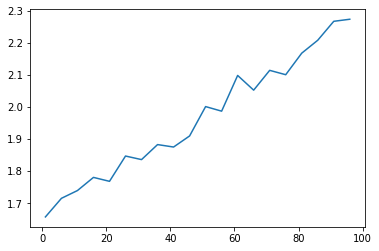

In [ ]:
# We evaluate the evolution of the RMSE with the number of latents and without mean corrections.
range_nlatents =  range(1,100, 5)
RMSE_nlatents = []
for nlatents in range_nlatents:
  print('Value of nlatents: ' + str(nlatents))
  #<SOL>
  algoLatent = SVD(n_factors = nlatents, biased = False)

  algoLatent.fit(trainset)
  predictions = algoLatent.test(testset)
  RMSE = accuracy.rmse(predictions)
  RMSE_nlatents.append(RMSE)
  #</SOL>
plt.figure()
plt.plot(range_nlatents, RMSE_nlatents)


#### **Exercise 14**:
Repeat the previous exercise using the mean factors (`biased = True`) and analyse the results.

Value of nlatents: 1
RMSE: 1.5011
Value of nlatents: 6
RMSE: 1.5019
Value of nlatents: 11
RMSE: 1.5053
Value of nlatents: 16
RMSE: 1.5053
Value of nlatents: 21
RMSE: 1.5044
Value of nlatents: 26
RMSE: 1.5077
Value of nlatents: 31
RMSE: 1.4986
Value of nlatents: 36
RMSE: 1.5043
Value of nlatents: 41
RMSE: 1.5063
Value of nlatents: 46
RMSE: 1.5097
Value of nlatents: 51
RMSE: 1.5085
Value of nlatents: 56
RMSE: 1.5080
Value of nlatents: 61
RMSE: 1.5113
Value of nlatents: 66
RMSE: 1.5127
Value of nlatents: 71
RMSE: 1.5091
Value of nlatents: 76
RMSE: 1.5117
Value of nlatents: 81
RMSE: 1.5105
Value of nlatents: 86
RMSE: 1.5096
Value of nlatents: 91
RMSE: 1.5065
Value of nlatents: 96
RMSE: 1.5112


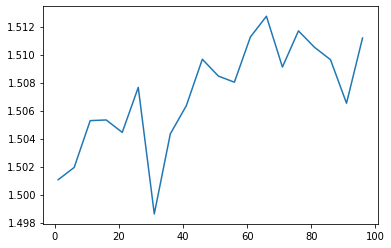

In [ ]:
# We evaluate the evolution of the RMSE with the number of latents and with mean corrections.

range_nlatents =  range(1,100, 5)
RMSE_nlatents = []
for nlatents in range_nlatents:
  print('Value of nlatents: ' + str(nlatents))
  #<SOL>
  algoLatent = SVD(n_factors = nlatents, biased = True)

  algoLatent.fit(trainset)
  predictions = algoLatent.test(testset)
  RMSE = accuracy.rmse(predictions)
  RMSE_nlatents.append(RMSE)
  #</SOL>
plt.figure()
plt.plot(range_nlatents, RMSE_nlatents)

**Conclusions**: As we can see, it seems that the full model (with mean factors) tends to show better results and to be less dependent on the number of latents used. Whereas in the previous case, the choice of the number of latents is critical (in this database using few latents gives good results, but this is **not** the usual scenario). 

### 6.2.2 Parameter validation

Let's analyze the model performance  by selecting this parameter (`n_factors`) with cross-validation. We will use our approach to redefine the training and test partitions in order to compare with the results obtained so far.

In [ ]:
# Usamos las variables datatrain y testset_gs que definimos antes

param_grid = {'n_factors': range(1,100, 5), 'biased': [True]}

# Fijamos refit=true para que reentrene el modelo final con todo el conjunto de datos                         
gs = GridSearchCV(SVD, param_grid, measures=['rmse'], cv=3, refit= True)
gs.fit(datatrain)

# Ahora evaluamos en el conjunto de test                                            
testset_gs = data.construct_testset(test_raw_ratings)      
predictions = gs.test(testset_gs)
print('RMSE en la particion de test:')                                          
RMSE = accuracy.rmse(predictions)    

RMSE en la particion de test:
RMSE: 1.5076


### 6.2.3 Latent analysis

Let's now analyse the latents obtained. To do so, we will train a model with only two latents and we will represent items in this (two-dimensional) latent space.

We can carry out a similar analysis with the users, but we do not have information about them to be able to extract any conclusion.

In [ ]:
algoLatent = SVD(n_factors = 2, biased=False, random_state =20)

# Train the algorithm on the trainset, and predict ratings for the testset
algoLatent.fit(trainset)

X = algoLatent.pu
Y = algoLatent.qi

In [ ]:
import numpy as np
items_id_Y = np.array([trainset.to_raw_iid(id) for id in trainset.all_items()])
latentsY = np.concatenate((items_id_Y[:, np.newaxis], Y), axis=1)

pd_items_id_Y = pd.DataFrame(latentsY, columns = ['bookID', 'Y0', 'Y1'])
pd_items_id_Y.Y0 = pd_items_id_Y.Y0.astype(float)
pd_items_id_Y.Y1 = pd_items_id_Y.Y1.astype(float)
pd_items_id_Y = pd.merge(pd_items_id_Y, books[['bookID','title', 'year']], on='bookID', how='inner')
pd_items_id_Y.head()

,bookID,Y0,Y1,title,year
0,0515131229,1.992169,2.652495,Dance upon the Air (Three Sisters Island Trilogy),2003
1,0425152251,1.982775,2.736753,Sophie's World: A Novel About the History of P...,1996
2,0515128546,1.852947,2.807685,Tears of the Moon (Irish Trilogy),2000
3,0380710218,1.564132,2.722077,Postmortem,1993
4,0440223202,2.120979,2.844538,Evening Class,1998


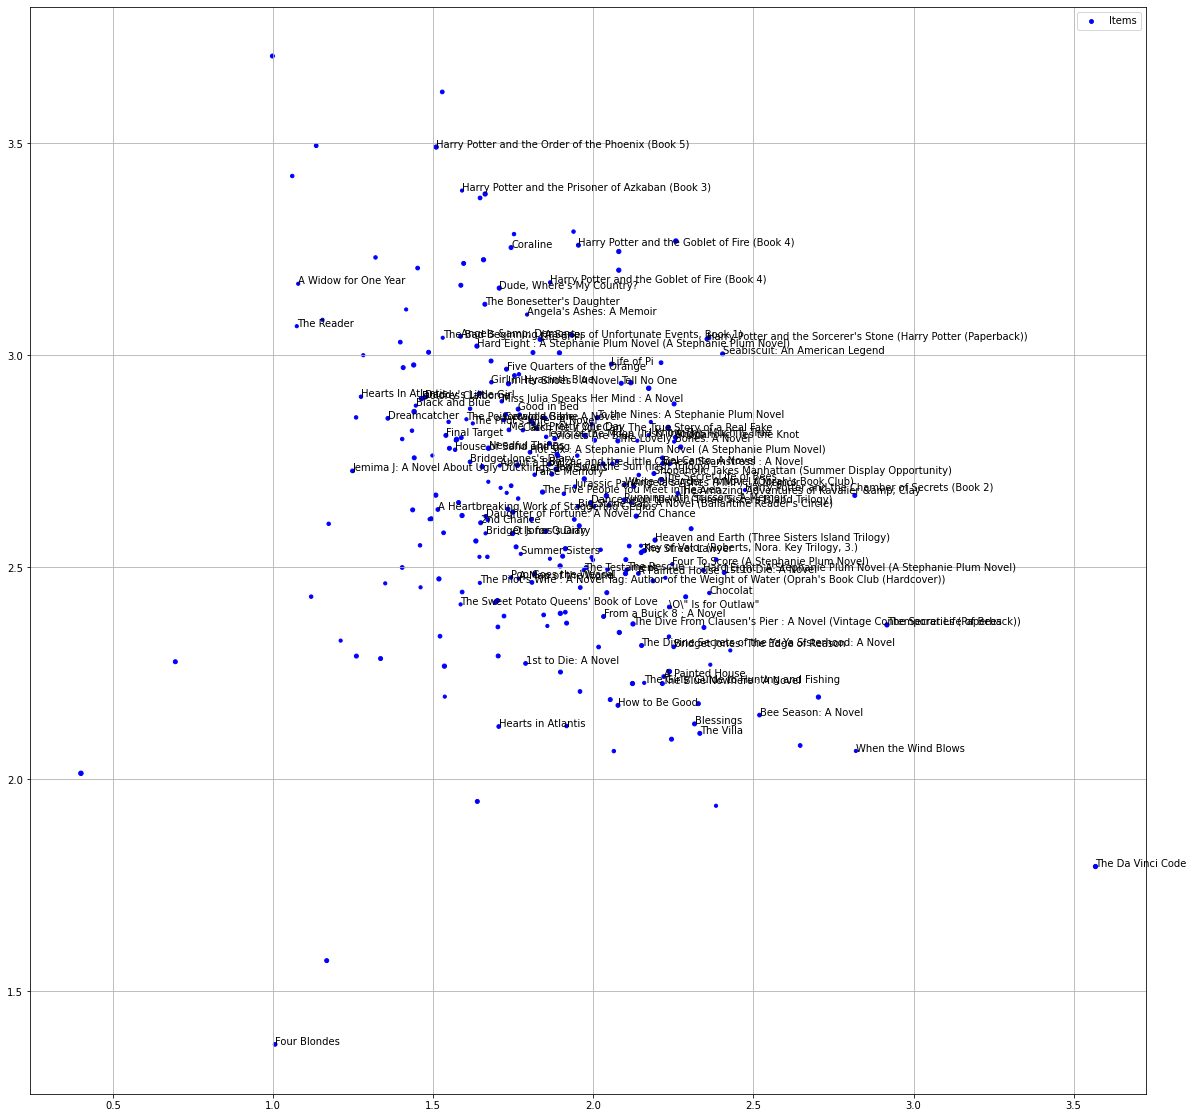

In [ ]:
fig, ax = plt.subplots(figsize=(20,20))


pd_items_id_Y = pd_items_id_Y.loc[pd_items_id_Y.year>1998]
# Point size related to the year
years = pd_items_id_Y.year.values
scale = 2*(years - 1994)
ax.scatter(pd_items_id_Y.Y0.values, pd_items_id_Y.Y1.values, c='blue', s=scale, label='Items')

ax.legend()
ax.grid(True)

titles = pd_items_id_Y.title.values
#for i, txt in enumerate(titles):
for i, txt in enumerate(titles[:100]):
    ax.annotate(txt, (pd_items_id_Y.Y0.values[i], pd_items_id_Y.Y1.values[i]), label='Title')


#ax.scatter(X[:, 0], X[:, 1], s=3, c='red')

plt.show()


# Other models included in Surprise

**Random score generator**.

It considers that the scores follow a Gaussian distribution with mean $\mu$ and variance $v$ and when it is asked for a prediction, it generates a random value from that distribution.

The values of $\mu$ and $v$ are calculated from the sample means and variances of the scores in the training set.

[NormalPredictor](https://surprise.readthedocs.io/en/stable/basic_algorithms.html#surprise.prediction_algorithms.random_pred.NormalPredictor)

**Mean-based generator**

This model assumes a user rating for an item is given by:

$$r_{u,i} = \mu + b_u + b_i$$

As you can see, this model is a simplified version of the SVD and the learning of these parameters is also done using the ALS.

[BaselineOnly](https://surprise.readthedocs.io/en/stable/basic_algorithms.html#surprise.prediction_algorithms.baseline_only.BaselineOnly)

**K-NN with baseline**

Modifies the neighbourhood-based model by including mean estimates. That is, using the above model carries out a first estimation of the ratings:
$$b_{u,i} = \mu + b_u + b_i$$

And then these estimatimations are used as a mean correction to estimate the ratings with a neighbourhood approximation

$$ \hat{r}_{u,i} = b_{u,i} + \frac{\sum_{v \in N_u} {\rm sim}(u,v) \left( r_{v,i}- b_{v,i}\right) }{\sum_{v \in N_u} {\rm sim}(u,v)} $$

[KNNBaseline](https://surprise.readthedocs.io/en/stable/knn_inspired.html#surprise.prediction_algorithms.knns.KNNBaseline)

**Slope One**
In this case, the predictions are given by:

$$ \hat{r}_{u,i} = \bar{r}_{u} + \sum_{j \in R_{u,i}}\frac{dev(i,j)}{\mid U_{i,j} \mid} $$

where $R_{u,i}$ is the set of items rated by user $u$ and where the deviation between the scores of item $i$ and item $j$, $dev(i,j)$, are measured as

$$dev(i,j) = \sum_{u \in U_{i,j}}\frac{r_{u,i}-r_{u,j}}{\mid U_{i,j} \mid}$$

where $U_{i,j}$ is the set of users who have rated items $i$ and $j$, and ${\mid U_{i,j} \mid}$  is the number of items in this set.

[SlopeOne](https://surprise.readthedocs.io/en/stable/slope_one.html#surprise.prediction_algorithms.slope_one.SlopeOne)

**Co-clustering**

This algorithm carries out a clustering of users and items, so you have $G$ groups of users and $H$ groups of items. For each of these groups it calculates:
* $C_{g}$: average rating of users in the $g$-th group.
* $C_{h}$: average rating of the items in the $h$-th group.
* $C_{g,h}$: average rating of the ratings of the users in the $g$-th group and the items in the $h$-th group.

If we further precompute the average score of each user and of each item, which we denote as $\bar{r_{u}}$ and $\bar{r_{i}}$, the predicion of the score of user $u$ (which belongs to group $g$) for item $i$ (which belongs to group $h$) is given by:
$$ \hat{r}_{u,i} = C_{g,h} + \left(\bar{r_{u}} -  C_{g}\right) + \left(\bar{r_{i}} -  C_{h}\right)$$



# Embeddings for colaborative filtering: Prod2Vec

We have just seen how the ALS method is able to obtain a low-dimensional representation of users and products. From this representation, we can obtain estimates of the scores that users would give to items that they have not yet scored. However, this low-dimensional representation could be used for other tasks, since by having each item/user characterised with a vector we can find similarities between them, we can apply a clustering, solve a classification/regression task, .....

Another way to obtain a vector representation (embedding) of the products of our recommender system is to borrow same ideas and tools from word2vec representation to obtain embeddings of products instead of words, for that reason this approach is called Prod2Vec.

Let's see how to obtain this Prod2Vec for a shopping recommendation system$^{(*)}$. To do so, let's start by loading the dataset.

$^{(*)}$ This dataset is a simplified version of the challenge "Instacart market basket analysis" from [Kaggle](https://www.kaggle.com/c/instacart-market-basket-analysis).

In [ ]:
import pandas as pd
pd.options.mode.chained_assignment = None # To silect warning in chained_assignment
product_df = pd.read_csv("http://www.tsc.uc3m.es/~vanessa/data_notebooks/market_basket/products.csv")
order_product_df = pd.read_csv("http://www.tsc.uc3m.es/~vanessa/data_notebooks/market_basket/market_basket_red_v2.zip").set_index('Unnamed: 0')


In this dataset we have two data tables, the first indicates the product information (it indicates what each `product_id` is).

In [ ]:
product_df

,product_id,product_name,aisle_id,department_id
0,1,Chocolate Sandwich Cookies,61,19
1,2,All-Seasons Salt,104,13
2,3,Robust Golden Unsweetened Oolong Tea,94,7
3,4,Smart Ones Classic Favorites Mini Rigatoni Wit...,38,1
4,5,Green Chile Anytime Sauce,5,13
...,...,...,...,...
49683,49684,"Vodka, Triple Distilled, Twist of Vanilla",124,5
49684,49685,En Croute Roast Hazelnut Cranberry,42,1
49685,49686,Artisan Baguette,112,3
49686,49687,Smartblend Healthy Metabolism Dry Cat Food,41,8


And, on the other hand, the table with orders that, for each purchase, indicates the products that have been bought and, in addition,  the order in which they are purchased. That is to say, it indicates the sequence of purchase of products.

In [ ]:
order_product_df.head()

,order_id,product_id,add_to_cart_order,user_id
Unnamed: 0,,,,
0,5,13176,1,156122
1,5,15005,2,156122
2,5,47329,3,156122
3,5,27966,4,156122
4,5,23909,5,156122


### Construction of the Prod2Vec representation

We can exploit the sequential structure given by the `order_product_df` table to see which products are usually accompanied by others, i.e., to define the context of each product. To do this, we only need to create sentence-like structures with the order in which products are purchased within the same order.

In [ ]:
order_product_list = order_product_df[['order_id','product_id']].values.tolist()

product_corpus = []
sentence = []
new_order_id = order_product_list[0][0]
for (order_id, product_id) in order_product_list:
    if new_order_id != order_id:
        product_corpus.append(sentence)
        sentence = []
        new_order_id = order_id
    sentence.append(str(product_id))


Let's look at the content of these lists

In [ ]:
# Function to help to analyze products
def toProductName(id):
    id = int(id)
    return product_df[product_df.product_id==id]['product_name'].values.tolist()[0]
toProductName(24852)

'Banana'

In [ ]:
# First sentence or first shopping list
id_list = 0
list_products = [toProductName(id_prod) for id_prod in product_corpus[id_list]]
print(list_products)

['Bag of Organic Bananas', 'Just Crisp, Parmesan', 'Fresh Fruit Salad', 'Organic Raspberries', '2% Reduced Fat Milk', 'Sensitive Toilet Paper', 'Natural Artesian Water, Mini & Mobile', 'Matzos, Thin, Tea', 'Boneless Skinless Chicken Breast Fillets', 'Mini Original Babybel Cheese', 'Macaroni And Cheese', 'Clementines', "Biscuits Orange Pim's", 'Dairy Milk Fruit & Nut Chocolate Bar', 'Artichokes', 'Apricot Preserves', 'One Ply Choose A Size Big Roll Paper Towel Rolls', 'Wafer, Chocolate', 'French Lavender Hand Wash', 'American Slices Cheese', 'Everyday  Facial Tissues', 'Organic Hass Avocado', 'Spaghetti Pasta', 'Meyer Lemon', 'Bag of Organic Lemons', 'Original Black Box Tablewater Cracker']


In [ ]:
# Second sentence or first shopping list
id_list = 1
list_products = [toProductName(id_prod) for id_prod in product_corpus[id_list]]
print(list_products)

['100% Recycled Paper Towels', 'Red Vine Tomato', 'Apricots', 'Watermelon Chunks', 'Organic Fat Free Milk', 'Sparkling Water Grapefruit', 'Organic Bosc Pear', 'Organic Raspberries', 'Organic Stage 4 Spinach Mango & Pear Baby Food', 'Ataulfo Mango', 'Globe Eggplant', 'Organic Unsalted Butter', 'Sesame Oil, Pure', 'Frozen Broccoli Florets', 'Organic Maple & Onion Baked Beans', 'Pear Kiwi & Kale Baby Food', 'Organic Fiber & Protein Pear Blueberry & Spinach Baby Food', 'Cilantro Pesto', 'Raspberry Preserves', 'Balsamic Reduction Traditional Balsamic', 'Pitted Prunes', 'Sweet Corn On The Cob', 'Organic Hazelnut Spread', 'Organic Baby Kale', 'Low Sodium Bacon', 'Asparagus', 'Organic Avocado', 'Basil, Asiago & Pine Nut Pesto Ravioli']


Now that we have our "corpus" of products or shopping lists, we can use the gensim `word2vec` function to build a `prod2vec`.

In [ ]:
from gensim.models import Word2Vec
model = Word2Vec(product_corpus, window=6, size=100, min_count=200)


### What are the most similar products?

We can use the prod2vec representation or the product embedding to find similar products:

* The most similar product to `banana` (24852) is ...

In [ ]:
def most_similar_readable(model, product_id):
    similar_list = [(product_id,1.0)]+model.wv.most_similar(str(product_id))
    
    return [( toProductName(int(id)), similarity ) for (id,similarity) in similar_list]

In [ ]:
pd.DataFrame(most_similar_readable(model, 24852), columns=['product','similarity'])

,product,similarity
0,Banana,1.000000
1,Bag of Organic Bananas,0.690302
2,Organic Banana,0.508779
3,Bartlett Pears,0.434171
4,Total 0% Greek Yogurt,0.427707
5,XL Emerald White Seedless Grapes,0.400756
6,Bosc Pear,0.381166
7,Fat Free Vanilla Yogurt,0.380007
8,100% Lactose Free Fat Free Milk,0.376680
9,Granny Smith Apples,0.364136


* The closest product to `Organic Whole Milk` (27845) is ... 

In [ ]:
pd.DataFrame(most_similar_readable(model, 27845), columns=['product','similarity'])

,product,similarity
0,Organic Whole Milk,1.000000
1,Organic Reduced Fat Milk,0.608968
2,Whole Organic Omega 3 Milk,0.572463
3,Organic Lowfat 1% Milk,0.539479
4,Organic Reduced Fat Omega-3 Milk,0.536738
5,Organic Whole Milk with DHA Omega-3,0.535674
6,Organic Whole Grassmilk Milk,0.532732
7,Organic Homogenized Whole Milk,0.517511
8,Lactose Free 2% Reduced Fat Milk,0.506006
9,"Milk, Organic, Vitamin D",0.498043


## Recommending products with prod2vec

Now, we can use these similarities to design a content based colaborative filtering system.

For this purpose, let's follow these steps:

### Build the rating matrix

In [ ]:
df_ratings = order_product_df.groupby(['user_id','product_id']).size().reset_index(name='ratings')
df_ratings 

,user_id,product_id,ratings
0,2,1559,1
1,2,2002,1
2,2,4957,1
3,2,5450,1
4,2,7781,1
...,...,...,...
4323310,206208,45608,1
4323311,206208,46069,1
4323312,206208,46271,1
4323313,206208,47626,2


### Make predictions

As we already know how to compute similarities, we can directly obtain predictions.

For a general case, the estimated rating for a user $u$ on item $i$ is given by
$$ \hat{r}_{u,i} = \frac{\sum_{j \in N_i^K} {\rm sim}(i,j) r_{u,j} }{\sum_{j \in N_i^K} {\rm sim}(i,j)}$$

where now $N_i^K$ are the $K$ most similar neighbours to item $i$.


In [ ]:
import numpy as np

# Obtain the contents included into prod2vec
list_products =list(model.wv.vocab)

# We choose a user (we can iterate it over all users)
user_id = 206208 	
df_user = df_ratings.loc[df_ratings['user_id']==user_id]

# We choose an item (we can iterate this over all products)
for product_id in ['26384']:# list_products:
  # Compute similar products to product_id and save this information                      
  sim_products = model.wv.most_similar(product_id, topn=40)
  df_user_sim_aux = df_user
  df_user_sim_aux['sim']=0
  for sim in sim_products:
    if int(sim[0]) in df_user_sim_aux['product_id'].values:
      # Check this product has been rated by the user and, then, we save this rating
      df_user_sim_aux['sim'].loc[df_user_sim_aux['product_id']==int(sim[0])] = sim[1]
 
  # We can print the similar products
  print('List of similar products')
  print(df_user_sim_aux.loc[df_user_sim_aux['sim']>0])
  # Now, we can make the prediction
  pred_rating = (df_user_sim_aux['ratings']*df_user_sim_aux['sim']).sum()/df_user_sim_aux['sim'].sum()
  print('The predicted scoring is: %2.2f' %pred_rating)

List of similar products
         user_id  product_id  ratings       sim
4323231   206208        6046        1  0.544185
4323263   206208       23644        1  0.534530
4323285   206208       36550        1  0.639597
The predicted scoring is: 1.00


## Other  Applications of prod2vec: product grouping

We can use the prod2vec representation to do product grouping by using it as input to a K-means. To do this we will train a k-means with 500 groups.

In [ ]:
from sklearn.cluster import KMeans
K=500

# Get product embeddings
prod_emb = model.wv.vectors

# Train Kmeans
kmeans = KMeans(n_clusters=K) # Define K-means with default parameters
kmeans.fit(prod_emb) # Trian it
y_kmeans = kmeans.predict(prod_emb) # Get the group/cluster identifier
centers = kmeans.cluster_centers_

Let's analyse the resulting clusters by looking at the products most similar to each centroid.

In [ ]:
def most_similar_to_centroid(model, center_emb):
    similar_list = model.wv.similar_by_vector(center_emb)
    
    return [( toProductName(int(id)), similarity ) for (id,similarity) in similar_list]

In [ ]:
center_id = 0
pd.DataFrame(most_similar_to_centroid(model, centers[center_id]), columns=['product','similarity'])

,product,similarity
0,Smoked Fresh Turkey Kielbasa,0.887625
1,Sweet Italian Chicken Sausage,0.828627
2,Blue Corn Taco Dinner Kit,0.799954
3,Flank Steak,0.786924
4,Air Chilled Organic Boneless Skinless Chicken ...,0.759943
5,Jumbo Lump Crab Cake,0.754036
6,Organic Apple Chicken Sausage,0.741504
7,Peppered Turkey Bacon,0.735783
8,Fiber Rich Wheat Tortillas Fajita Size,0.733229
9,Boneless Beef Sirloin Steak,0.732070


In [ ]:
center_id = 100
pd.DataFrame(most_similar_to_centroid(model, centers[center_id]), columns=['product','similarity'])

,product,similarity
0,Organic Beef Uncured Hot Dogs,0.838298
1,Organic Elbows & Creamy Mild Cheddar Sauce Cre...,0.810525
2,Buttermilk Pancakes 8 Count,0.802060
3,Microwavable Mac & Cheese,0.784607
4,Kidz All Natural Baked Chicken Nuggets,0.782562
5,Sesame Street Organic Homestyle Mini Pancakes,0.779830
6,Mini Chocolate Chip Waffles,0.778882
7,Organic Beef Hot Dogs,0.768770
8,Organic Turkey Hot Dogs,0.766371
9,The Great Organic Uncured Chicken Hot Dogs,0.764743


In [ ]:
center_id = 200
pd.DataFrame(most_similar_to_centroid(model, centers[center_id]), columns=['product','similarity'])

,product,similarity
0,Traditional 98% Fat Free,0.961909
1,Original Taco Seasoning Mix,0.946616
2,Taco Spices and Seasonings,0.930467
3,Yellow Corn Taco Shells,0.919320
4,Large Burrito Flour Tortillas,0.904104
5,Mild Enchilada Sauce,0.900536
6,White Corn Tortillas,0.891829
7,Traditional No Fat Refried Beans,0.891179
8,50% Less Sodium Black Beans,0.868201
9,Flour Tortilla,0.867294
